# 0. Gravitational waves regression

In this notebook, we attempt to build a neural network to estimate two masses in gravitational waves. 

Gravitational waves are disturbances in the curvature of spacetime, generated by accelerated masses, that propagate as waves outward from their source at the speed of light. The gravitational waves used in this tutorial are generated with two masses $m_1$ and $m_2$. The detial description of the data are published in [LALSuite IMRPhenomD generator](https://arxiv.org/pdf/1508.07250.pdf). 

The aim of this work is to estimate two masses $m_1$ and $m_2$ using 1d convolutional and dense layers. 


In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Multiply, Add, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# sklearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.datasets
from sklearn.preprocessing import StandardScaler

# helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import join

data_path = 'data'

## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [ ]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [ ]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

OK
75 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 75 not upgraded.
Need to get 12.0 MB of archives.
After this operation, 28.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.40.0_amd64.deb ...
Unpacking gcsfuse (0.40.0) ...
Setting up gcsfuse (0.40.0) ...
2022/03/04 13:45:20.318677 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/sciml-workshop-data
2022/03/04 13:45:20.357973 Opening GCS connection...
2022/03/04 13:45:20.597085 Mounting file system "sciml-workshop"...
2022/03/04 13:45:20.654062 File system has been successfully mounted.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  34283      0 --:--:-- --:--:-- --:--:-- 34283




Updated property [core/project].


---

# 1. Load the dataset

### Read raw data

The data is stored in 'Physics/gravitational_wave_dataset.npz', containing 2,000 signals: 1,000 examples of signals and 1,000 examples of pure noise. The signals are 1 second long with a sample rate of 8196. We will use 1,000 examples of signals for a regression task.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
grav_wave = np.load(join(data_path, 'Physics/gravitational_wave_dataset.npy'), allow_pickle=True)
```
    
</p>
</details>

In [ ]:
grav_wave = np.load(join(data_path, 'Physics/gravitational_wave_dataset.npy'), allow_pickle=True)

In [ ]:
def prepare_datset(X, target = 'regression'):
    if target == 'regression':
        x = np.expand_dims(np.sum(np.stack(X[:1000, 2]), axis = -1), axis = -1).astype(np.float32)
        y = np.stack([[w[0] for w in  grav_wave[j, [3, 4]]] for j in np.arange(1000)])
        y = y.reshape(len(x), 2).astype(np.float32)
        
    elif target == 'classification':
        x = np.expand_dims(np.sum(np.stack(X[:, 1]), axis = -1), axis = -1)
        y = X[:, 0].astype(np.int)
        
    return x, y

Prepare a dataset for a regression task using the prepare_dataset function and split it using the train_test_split funtion

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
x, y = prepare_datset(grav_wave, target = 'regression')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)    
```
    
</p>
</details>

In [ ]:
x, y = prepare_datset(grav_wave, target = 'regression')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)    

x_train shape:  (800, 8192, 1)
y_train shape:  (800, 2)
x_test shape:  (200, 8192, 1)
y_test shape:  (200, 2)


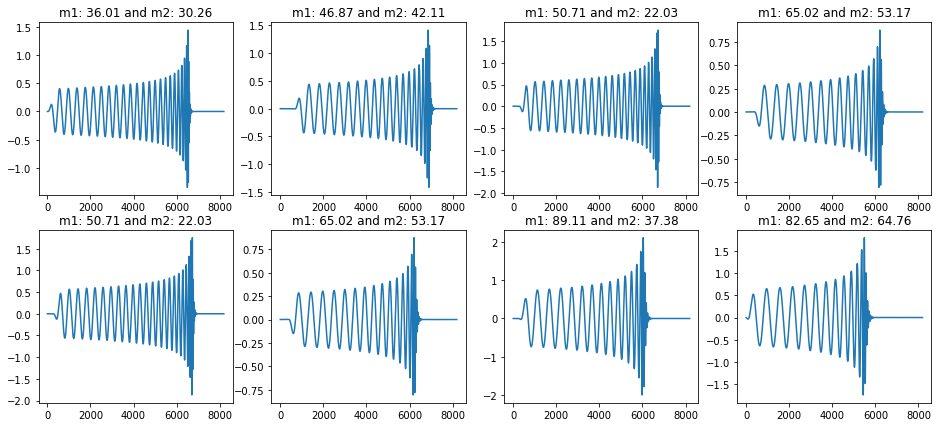

In [ ]:
fig, axes = plt.subplots(2, 4, figsize = (16, 7))

rnd_idx = np.random.choice(len(x_train), 8)
for i in range(2):
    for j in range(4):
        axes[i][j].plot(x_train[rnd_idx[2*i+j]])
        axes[i][j].set_title('m1: {:.2f} and m2: {:.2f}'.format(y_train[rnd_idx[2*i+j]][0], y_train[rnd_idx[2*i+j]][1]))

---

# 2. Build the network

We will build a linear regression using sklearn and a 1D-convolutional neural network to compare their results.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# fit linear regression model
model = LinearRegression().fit(x_train.reshape(-1, 8192), y_train)
# make predictions
y_train_pred = model.predict(x_train.reshape(-1, 8192))
y_test_pred = model.predict(x_test.reshape(-1, 8192))
```
    
</p>
</details>


In [ ]:
# fit linear regression model
model = LinearRegression().fit(x_train.reshape(-1, 8192), y_train)
# make predictions
y_train_pred = model.predict(x_train.reshape(-1, 8192))
y_test_pred = model.predict(x_test.reshape(-1, 8192))

In [ ]:
# compute some fitting error
print('MSE on the train set = %f ' % metrics.mean_squared_error(y_train, y_train_pred))
print('MAE on the train set = %f ' % metrics.mean_absolute_error(y_train, y_train_pred))
print('MSE on the test set = %f ' % metrics.mean_squared_error(y_test, y_test_pred))
print('MAE on the test set = %f ' % metrics.mean_absolute_error(y_test, y_test_pred))

MSE on the train set = 59.495346 
MAE on the train set = 5.593725 
MSE on the test set = 52415070208.000000 
MAE on the test set = 28487.644531 


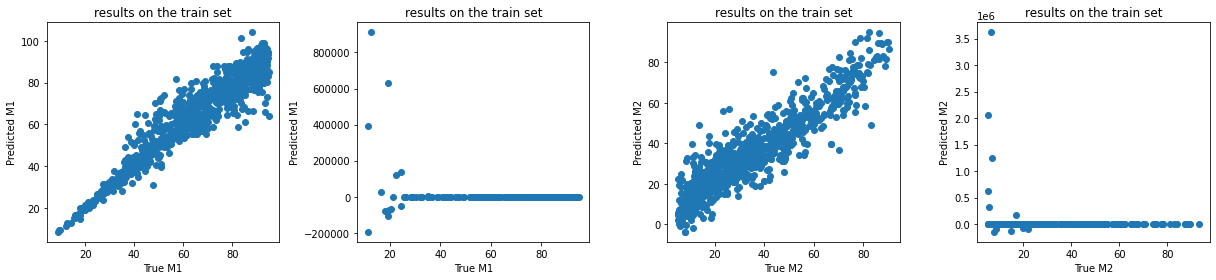

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (17, 4))

axes[0].scatter(y_train[:, 0], y_train_pred[:, 0])
axes[0].set_title('results on the train set')
axes[0].set_xlabel('True M1')
axes[0].set_ylabel('Predicted M1')

axes[1].scatter(y_test[:, 0], y_test_pred[:, 0])
axes[1].set_title('results on the train set')
axes[1].set_xlabel('True M1')
axes[1].set_ylabel('Predicted M1')

axes[2].scatter(y_train[:, 1], y_train_pred[:, 1])
axes[2].set_title('results on the train set')
axes[2].set_xlabel('True M2')
axes[2].set_ylabel('Predicted M2')

axes[3].scatter(y_test[:, 1], y_test_pred[:, 1])
axes[3].set_title('results on the train set')
axes[3].set_xlabel('True M2')
axes[3].set_ylabel('Predicted M2')

fig.tight_layout()

### Use 1D-convolutional layers to build a neural network

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
model = Sequential()
model.add(Input(shape=(x_train.shape[1],1,)))

model.add(Conv1D(filters=16, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=32, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2))        

opt = tf.keras.optimizers.Adam(0.01)
model.compile(loss="mse", optimizer=opt)



stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min", restore_best_weights=True,patience=5)
history = model.fit(x_train, y_train, epochs=99, batch_size=64, 
                             validation_split = 0.2 ,callbacks=[stopper])
```
    
</p>
</details>

In [ ]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1],1,)))

model.add(Conv1D(filters=16, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=32, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2))        

opt = tf.keras.optimizers.Adam(0.01)
model.compile(loss="mse", optimizer=opt)



stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min", restore_best_weights=True,patience=5)
history = model.fit(x_train, y_train, epochs=99, batch_size=64, 
                             validation_split = 0.2 ,callbacks=[stopper])

Epoch 1/99
10/10 [==============================] - 6s 476ms/step - loss: 1360.5208 - val_loss: 714.8714
Epoch 2/99
10/10 [==============================] - 4s 447ms/step - loss: 397.1458 - val_loss: 261.5037
Epoch 3/99
10/10 [==============================] - 4s 449ms/step - loss: 293.7314 - val_loss: 304.9781
Epoch 4/99
10/10 [==============================] - 5s 488ms/step - loss: 246.6726 - val_loss: 209.3506
Epoch 5/99
10/10 [==============================] - 4s 444ms/step - loss: 193.0813 - val_loss: 182.8732
Epoch 6/99
10/10 [==============================] - 4s 442ms/step - loss: 167.0533 - val_loss: 176.2292
Epoch 7/99
10/10 [==============================] - 4s 453ms/step - loss: 166.0723 - val_loss: 173.5077
Epoch 8/99
10/10 [==============================] - 4s 452ms/step - loss: 144.4872 - val_loss: 157.4451
Epoch 9/99
10/10 [==============================] - 4s 444ms/step - loss: 122.0222 - val_loss: 140.1631
Epoch 10/99
10/10 [==============================] - 4s 451ms/s

# 3. Analyse results 

### prediction

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
```
    
</p>
</details>

In [ ]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [ ]:
# compute some fitting error
print('MSE on the train set = %f ' % metrics.mean_squared_error(y_train, y_train_pred))
print('MAE on the train set = %f ' % metrics.mean_absolute_error(y_train, y_train_pred))
print('MSE on the test set = %f ' % metrics.mean_squared_error(y_test, y_test_pred))
print('MAE on the test set = %f ' % metrics.mean_absolute_error(y_test, y_test_pred))

MSE on the train set = 33.527473 
MAE on the train set = 4.413369 
MSE on the test set = 67.843658 
MAE on the test set = 6.498931 


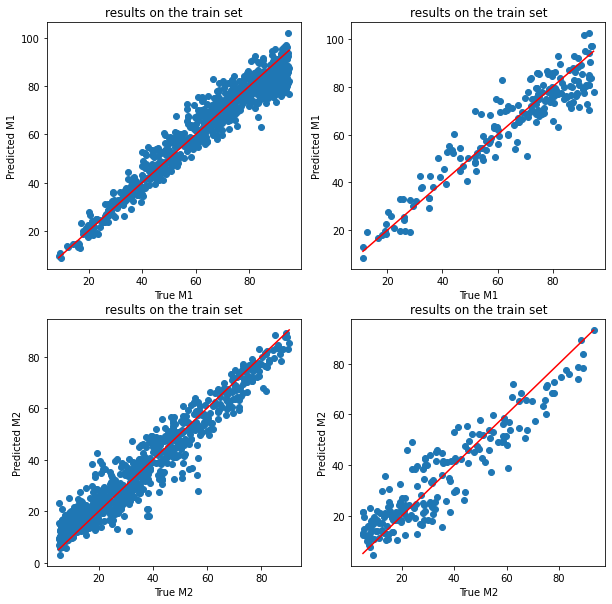

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))

axes[0][0].scatter(y_train[:, 0], y_train_pred[:, 0])
axes[0][0].plot([y_train[:, 0].min(), y_train[:, 0].max()], [y_train[:, 0].min(), y_train[:, 0].max()],'r')
axes[0][0].set_title('results on the train set')
axes[0][0].set_xlabel('True M1')
axes[0][0].set_ylabel('Predicted M1')


axes[0][1].scatter(y_test[:, 0], y_test_pred[:, 0])
axes[0][1].plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()],'r')
axes[0][1].set_title('results on the train set')
axes[0][1].set_xlabel('True M1')
axes[0][1].set_ylabel('Predicted M1')


axes[1][0].scatter(y_train[:, 1], y_train_pred[:, 1])
axes[1][0].plot([y_train[:, 1].min(), y_train[:, 1].max()], [y_train[:, 1].min(), y_train[:, 1].max()],'r')
axes[1][0].set_title('results on the train set')
axes[1][0].set_xlabel('True M2')
axes[1][0].set_ylabel('Predicted M2')


axes[1][1].scatter(y_test[:, 1], y_test_pred[:, 1])
axes[1][1].plot([y_test[:, 1].min(), y_test[:, 1].max()], [y_test[:, 1].min(), y_test[:, 1].max()],'r')
axes[1][1].set_title('results on the train set')
axes[1][1].set_xlabel('True M2')
axes[1][1].set_ylabel('Predicted M2')
plt.show()


---

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)); 
* Change the architeture and activation functions of neural networks to improve the performance on the test set